# Remove Climatological Mean Annual Cycle and Detrend Data<a id='top' class="tocSkip"> </a>

This tutorial shows how to use [CDAT](https://cdat.llnl.gov) to remove the climatological mean annual cycle and detrend data - a commonly-used technique prior to detailed climate data analysis of monthly anomalies.

The data considered in this notebook are monthly-mean surface air temperatures gridded over the United States and spanning the years 1850 - 1990. The original dataset is complete, but it is artificially modified in this notebook by "masking" some values, yielding an incomplete dataset with some values "missing" (which is a common problem in analysis of climate data). The analysis procedure involves three major steps:

1) Remove the climatological annual cycle yielding monthly-mean departures
2) Spatially average over the domain.
3) Remove the time-mean and the linear trend.

When there are missing values in the dataset (as in the sample calculations below), the final detrended time-series will depend on the order in which these steps are executed.  Here we examine options for detrending the data, and we show that slightly different results are generated depending on the order in which operations are performed.  More sophisticated treatments (not discussed here) involving appropriately weighting samples and collections of samples should be considered for datasets that only sparsely cover the time and space domains.


To [download this Jupyter Notebook](Detrend_data.ipynb), right click on the link and choose "Download Linked File As..." or "Save Link as...". Remember where you saved the downloaded file, which should have an .ipynb extension. (You'll need to launch the Jupyter notebook or JupyterLab instance from the location where you store the notebook file.)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-Notebook-and-Data" data-toc-modified-id="Prepare-Notebook-and-Data-1">Prepare Notebook and Data</a></span><ul class="toc-item"><li><span><a href="#Download-Data" data-toc-modified-id="Download-Data-1.1">Download Data</a></span></li><li><span><a href="#Open-Data-File,-Extract-Variable" data-toc-modified-id="Open-Data-File,-Extract-Variable-1.2">Open Data File, Extract Variable</a></span></li></ul></li><li><span><a href="#Data-Exploration" data-toc-modified-id="Data-Exploration-2">Data Exploration</a></span></li><li><span><a href="#Order-of-Operations-Matters" data-toc-modified-id="Order-of-Operations-Matters-3">Order of Operations Matters</a></span><ul class="toc-item"><li><span><a href="#Numerical-Example" data-toc-modified-id="Numerical-Example-3.1">Numerical Example</a></span></li><li><span><a href="#Removing-the-Climatological-Annual-Cycle" data-toc-modified-id="Removing-the-Climatological-Annual-Cycle-3.2">Removing the Climatological Annual Cycle</a></span><ul class="toc-item"><li><span><a href="#Processing-Option-1:-Remove-the-annual-cycle,-then-spatially-average-to-create-a-single-time-series" data-toc-modified-id="Processing-Option-1:-Remove-the-annual-cycle,-then-spatially-average-to-create-a-single-time-series-3.2.1">Processing Option 1: Remove the annual cycle, then spatially average to create a single time series</a></span></li><li><span><a href="#Processing-Option-2:-Spatially-average-data-to-obtain-a-single-time-series,-then-remove-the-annual-cycle" data-toc-modified-id="Processing-Option-2:-Spatially-average-data-to-obtain-a-single-time-series,-then-remove-the-annual-cycle-3.2.2">Processing Option 2: Spatially average data to obtain a single time-series, then remove the annual cycle</a></span></li></ul></li></ul></li><li><span><a href="#Detrend-Data" data-toc-modified-id="Detrend-Data-4">Detrend Data</a></span><ul class="toc-item"><li><span><a href="#Consider-Two-Options" data-toc-modified-id="Consider-Two-Options-4.1">Consider Two Options</a></span></li><li><span><a href="#Removing-the-Trend" data-toc-modified-id="Removing-the-Trend-4.2">Removing the Trend</a></span></li></ul></li></ul></div>

# Prepare Notebook and Data
[Back to Top](#top)

In [1]:
from __future__ import print_function
import cdms2
import MV2
import genutil
import cdutil
import vcs
import os
import requests

## Download Data
The following CMIP5 NetCDF file contains Near-Surface Air Temperature data in degrees Kelvin (K) over North America. It is downloaded to the directory where this notebook is stored.

In [2]:
filename = 'tas_Amon_IPSL-CM5A-LR_1pctCO2_r1i1p1_185001-198912.nc'
if not os.path.exists(filename):
    r = requests.get("https://cdat.llnl.gov/cdat/sample_data/notebooks/{}".format(filename), stream=True)
    with open(filename,"wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter local_filename keep-alive new chunks
                f.write(chunk)

## Open Data File, Extract Variable
The following two lines of code open the file just downloaded to your local computer (`filename`), extract data for the Near-Surface Air Temperature (`tas`), and assign it to the variable `data`.

In [3]:
f = cdms2.open(filename)

data = f("tas")

The following line of code uses the `.info()` method to allow us to take a quick look at the structure of the temperature data stored in the ```data``` variable.  

There are 1680 different time values which are measured as "days since 1850-01-01 00:00:00". The range of the time values is the difference between the last value (51084.5) and the first value (15.5) which equals 51069 days. If we divide this range (51069) by the number of intervals in the dataset (1680-1), we get (51069/(1680-1)) = 30.416 days, which is the average time duration for each data point. This tells us that we are working with monthly data.

Since this file is a subset of the globe, the data cover 13 latitude bands and 16 longitude values. The first and last values of latitude (~25.6 to ~48.3) and longitude (-123.75 to -67.5) tell us the data cover the continental United States.

In [4]:
data.info()

*** Description of Slab tas ***
id: tas
shape: (1680, 13, 16)
filename: 
missing_value: 1e+20
comments: 
grid_name: <None>
grid_type: generic
time_statistic: 
long_name: Near-Surface Air Temperature
units: K
tileIndex: None
original_name: t2m
associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc areacella: areacella_fx_IPSL-CM5A-LR_1pctCO2_r0i0p0.nc
coordinates: height
standard_name: air_temperature
cell_methods: time: mean (interval: 30 minutes)
cell_measures: area: areacella
history: 2011-03-07T11:45:34Z altered by CMOR: Treated scalar dimension: 'height'. 2011-03-07T11:45:34Z altered by CMOR: replaced missing value flag (9.96921e+36) with standard missing value (1e+20). 2011-03-07T11:45:34Z altered by CMOR: Inverted axis: lat.
Grid has Python id 0x120f8b390.
Gridtype: generic
Grid shape: (13, 16)
Order: yx
** Dimension 1 **
   id: time
   Designated a time axis.
   units:  days since 1850-01-01 00:00:0

# Data Exploration
[Back to Top](#top)

First, to get a feel for the data, let's spatially average the data over the entire domain to create a time series of the mean temperature for the region. In creating this time series, the `averager` function will take the temperature data for the entire region and spatially average it to yield a single temperature value as a function of time (i.e., the latitude and longitude dimensions are removed by this action, as shown with the `.shape` method.)

In [5]:
data_ts = genutil.averager(data, axis='xy')
data_ts.shape

(1680,)

In the next line of code, let's plot this time series.

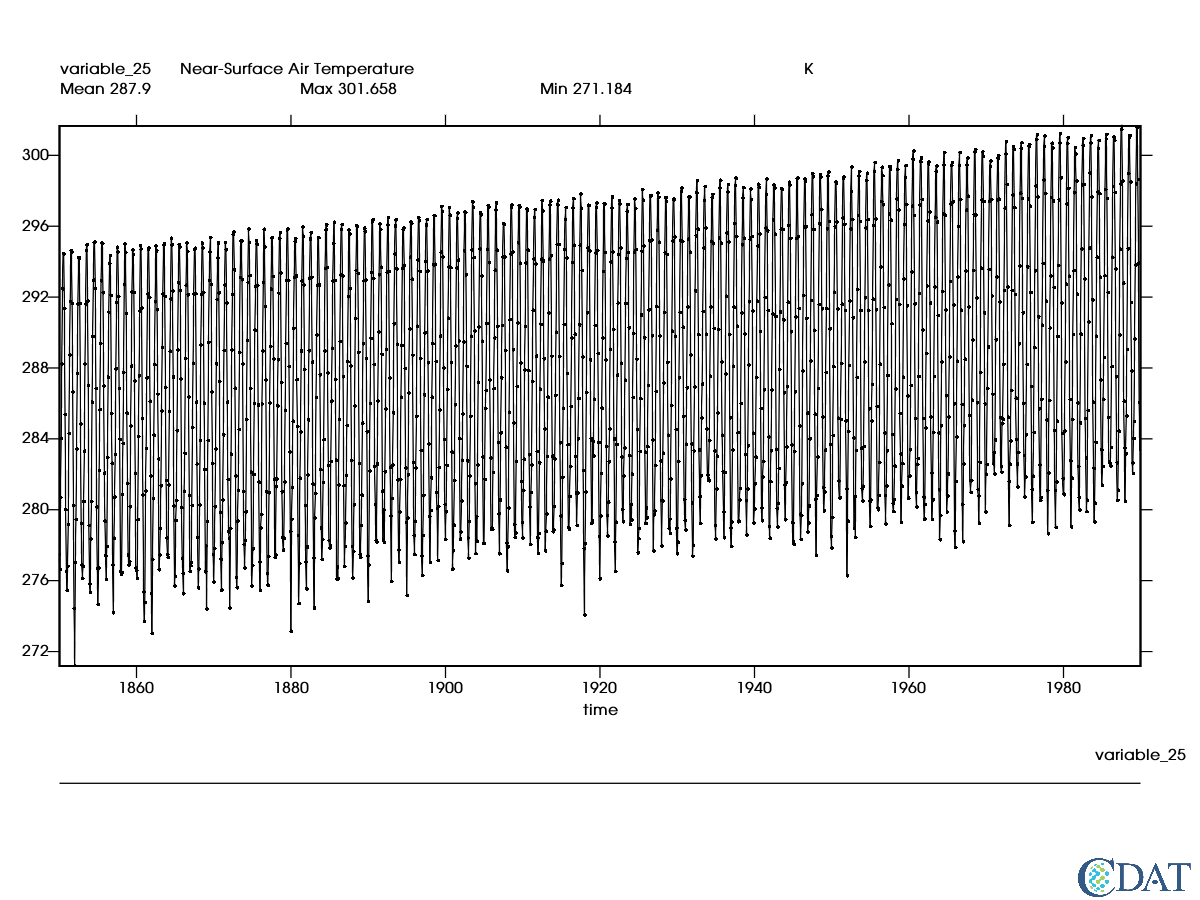

In [6]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(data_ts, line)

The figure above shows that the surface temperature averaged over the U.S. is characterized by a pronounced annual cycle and a long term trend with some year to year variability.  The goal of the remainder of this analysis is remove both the climatological mean annual cycle and the long term trend.  This procedure leads to a filtered time series representing monthly temperature anomalies characterizing variability that cannot be explained by annual cycle forcing or any long-term changes in climate forcing.    

But first, let's look at a numerical example, which illustrates that the order in which you perform operations can make a difference when a dataset is incomplete (i.e., includes "masked" or "missing" data).

# Order of Operations Matters

## Numerical Example
[Back to Top](#top)

If data are missing from a dataset, the order of operations can matter. The following is a numerical example of averaging values two different ways. 

Let's say we have the following dataset, which is a function of X and Y:

| | Y1 | Y2 | Y3 | Y4 |
|:---:|:---:|:---:|:---:|:---:|
| X1 | *3* | *4* | - | *7* |
| X2 | - | *5* | - | - |
| X3 | *1* | *2* | *5* | *5* |
| X4 | - | - | *6* | *4* |


Creating this dataset using a numpy array we have:

In [7]:
import numpy
array = numpy.array([[3,4,999,7], [999,5,999,999],[1,2,5,5],[999,999,6,4.]])
array

array([[  3.,   4., 999.,   7.],
       [999.,   5., 999., 999.],
       [  1.,   2.,   5.,   5.],
       [999., 999.,   6.,   4.]])

Masking the 999 values leads to the following:

In [8]:
masked = numpy.ma.masked_equal(array, 999.)
masked

masked_array(
  data=[[3.0, 4.0, --, 7.0],
        [--, 5.0, --, --],
        [1.0, 2.0, 5.0, 5.0],
        [--, --, 6.0, 4.0]],
  mask=[[False, False,  True, False],
        [ True, False,  True,  True],
        [False, False, False, False],
        [ True,  True, False, False]],
  fill_value=999.0)

**If we average over X first, then average over Y, we get (4.667 + 5.000 + 3.250 + 5.000) / 4 = 4.479**

| | Y1 | Y2 | Y3 | Y4 | Average |
|---|---|---|---|---|---|
| X1 | *3* | *4* | - | *7* | **4.667**
| X2 | - | *5* | - | - | **5.000**
| X3 | *1* | *2* | *5* | *5* | **3.250**
| X4 | - | - | *6* | *4* | **5.000**
| Average |  |  |  |  | **4.479**

Verifying this with code gives:

In [9]:
print("X, Y:", numpy.ma.average(numpy.ma.average(masked, axis=-1)))

X, Y: 4.479166666666667


**If we average over Y first, then over X, we get (2.000 + 3.667 + 5.500 + 5.333) / 4 = 4.125**

| | Y1 | Y2 | Y3 | Y4 | Average |
|---|---|---|---|---|---|
| X1 | *3* | *4* | - | *7* | 
| X2 | - | *5* | - | - | 
| X3 | *1* | *2* | *5* | *5* | 
| X4 | - | - | *6* | *4* | 
| Average | **2.000** | **3.667** | **5.500** | **5.333** | **4.125**

Verifying this with code yields:

In [10]:
print("Y, X:", numpy.ma.average(numpy.ma.average(masked, axis=0)))

Y, X: 4.125


**Finally, if we average using all 16 cells at once (but, of course, exclude those with missing data), we get (3 + 4 + 7 + 5 + 1 + 2 + 5 + 5 + 6 + 4) / 10 = 4.200**

In [11]:
print("All:", numpy.ma.average(masked))

All: 4.2


We get three different overall means (4.479, 4.125, or 4.200) depending on our processing choices (specifically the order of operations).  (Note that with appropriate weighting, which is *not* done here, a consistent mean *can* be obtained, independent of the order of operations. From the first example of averaging over X, then Y, since the total number of values in the dataset is 10, the proper weighting would be: 4.667(3/10) + 5.000(1/10) + 3.250(4/10) + 5.000(2/10) = 4.200.)  

When additional processing steps are involved, ordering can affect results in more complex ways, as in the next example.

## Removing the Climatological Annual Cycle
[Back to Top](#top)

Before detrending a time series, it is often best to filter it by removing the climatological mean annual cycle; in fact, this may be a requirement for particular types of analyses. In the case of a time series that does not span a representative number of years, an accurate determination of the trend of interest may require removal of the climatological mean annual cycle. To see why, consider a temperature time series starting in January and ending in July a year and a half later. Over Northern Hemisphere continents with a large annual cycle, the ending temperature would be much higher than the beginning temperature simply due to the usual seasonal changes in temperature. A linear fit to the time-series would result in a trend that would not reflect any real change in climate but just the particulars of the time period treated. Thus, before computing a trend it is best to remove the climatological annual cycle.

The surface temperature data considered earlier has no missing data, but more often than not observational data sets are incomplete. For purposes of illustration, we therefore will first modify the surface temperature dataset by designating certain values as "missing". Specifically, we'll treat as "missing" (i.e., delete or mask) all data values that are within 2 degrees of the maximum temperature (`data.max()-2`) and store the result in `datamskd`.

In [12]:
datamskd = MV2.masked_greater(data, data.max()-2)

***Karl thinks it would be good to plot here (as a function of time) the number of grid cells with missing data.  Would that be difficult?  This would help in interpreting the later time-series.***

In [13]:
# code for plotting number of grid cells w/ missing data as a function of time.

We now consider what order to carry out the operations needed to remove the climatological mean annual cycle:

1. Remove the climatological annual cycle yielding monthly-mean departures
2. Spatially average over the domain.

We examine the two ordering options, with steps performed in the order shown above and then in the reverse order.

### Processing Option 1: Remove the annual cycle, then spatially average to create a single time series
[Back to Top](#top)

First at each location (grid cell) we will remove the climatological mean annual cycle to produce monthly mean departures or anomalies relative to the climatological annual cycle. Then we will spatially average the anomalies to produce a time-series of regional-mean anomalies.

In the next line of code, the `ANNUALCYCLE.departures` calculates the average monthly temperature value for each of the 12 months in a year over the complete time period for each location in the input data file and determines the departure of each temperature (at each time and location) from this average or climatological monthly value.

For example, once an average January value for the entire dataset has been calculated, each January value in the dataset is subtracted from that average January value to yield a series of January departures for each year in the data set. Since there are 1680 months in the dataset, there are 1680/12 = 140 years of data, and therefore 140 January departures. Since there are 140 Februaries, 140 Marches, etc. there are 140 departures x 12 months = 1680 departures for each location in the dataset, as the `.shape` method shows (1680 departure values by 13 latitude bands, by 16 longitude values).

In [14]:
datamskd_departures = cdutil.times.ANNUALCYCLE.departures(datamskd) # extract the departures of the masked data.

In [15]:
datamskd_departures.shape

(1680, 13, 16)

Now that we have a time series of monthly departures at each grid cell, we can spatially average them over the entire domain to obtain a single time-series for the regional-mean monthly anomalies:

In [16]:
datamskd_departures_ts = genutil.averager(datamskd_departures, axis='xy') # create time series of the masked data departures.

Using the `.shape` method below verifies that the resulting spatially averaged data no longer have latitude and longitude information.

In [17]:
datamskd_departures_ts.shape

(1680,)

Let's plot the resulting time series of the departures (i.e. the result of removing the annual cycle before creating the time series).

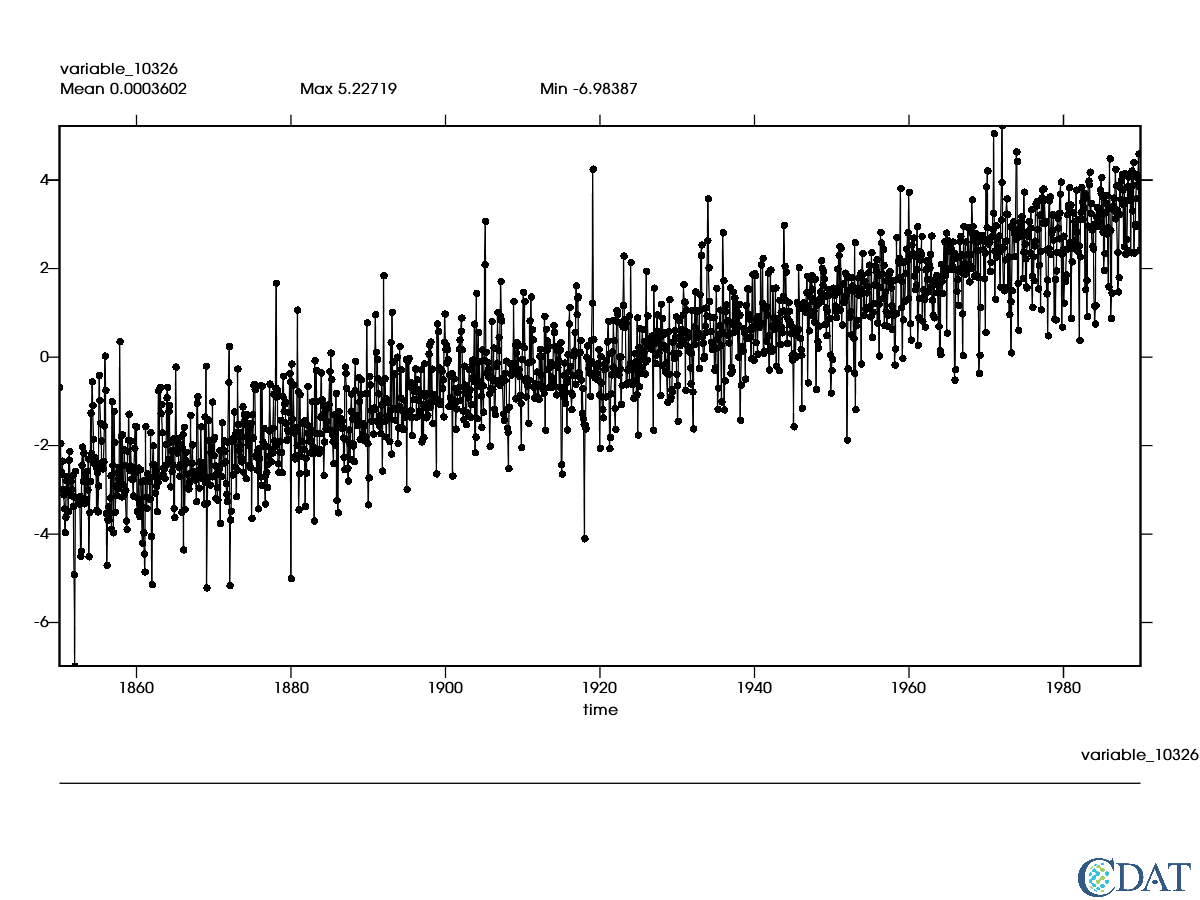

In [18]:
x.clear()
x.plot(datamskd_departures_ts)

Notice how, with the annual cycle removed, it is easier to see the trend and which months are anomalously warm or cold (compared to the climatological mean temperature).

It should be noted that with the order of operations executed under this option, we cannot expect the mean of the anomalies for a given month of the year summed over all years to be exactly zero. Although the anomalies at the individual cells do indeed have zero means, this cannot be guaranteed when they are averaged spatially if there are missing data. This is because the order of averaging data sequentially over two dimensions when there are missing values depends on the order it is done, as demonstrated earlier. This means that under Processing Option 1, additional care must be taken.  Although applying appropriate weighting during the averaging procedures (over time and over space) can remedy the problem, an easier solution is to remove a mean value (over all years for a given month of the year) from that month's temperature anomaly (`datmskd_departures_ts`) to obtain anomalies (`datmskd_departures_ts_corrected`) with means of zero:

In [19]:
datamskd_departures_ts_corrected = cdutil.times.ANNUALCYCLE.departures(datamskd_departures_ts)

In [20]:
datamskd_departures_ts_corrected.shape

(1680,)

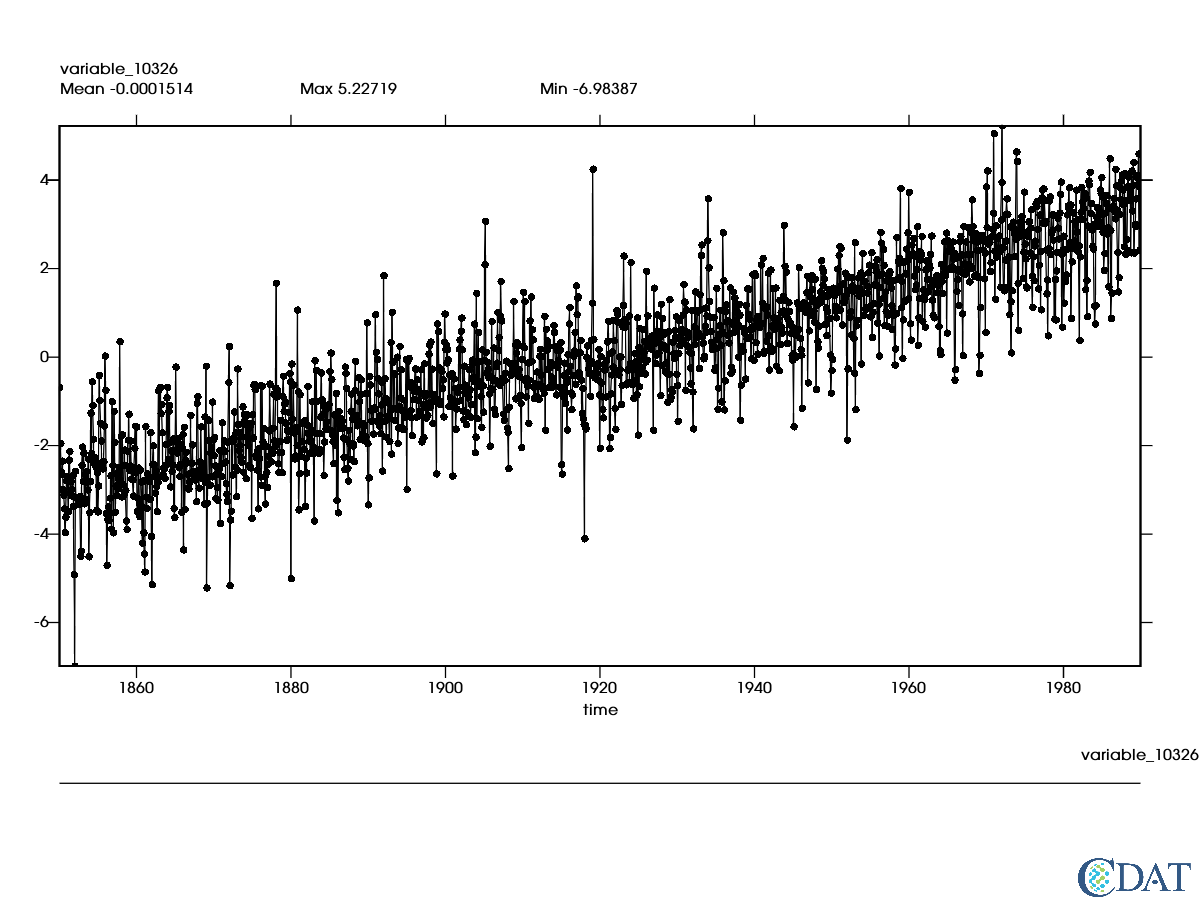

In [21]:
x.clear()
x.plot(datamskd_departures_ts_corrected)

### Processing Option 2: Spatially average data to obtain a single time-series, then remove the annual cycle
[Back to Top](#top)

Now let's reverse the order of performing the operations. We first calculate the spatially-averaged time series and then remove the annual cycle.

We calculate the time series characterizing area-mean temperature for the masked dataset by spatially averaging the temperature values over all latitude and longitude locations to give a single global temperature time series. (Again, the `.shape` method, shows we are looking at 1680 values with no latitude or longitude, as expected.)

In [22]:
datamskd_ts = genutil.averager(datamskd, axis='xy')

In [23]:
datamskd_ts.shape

(1680,)

Let's take a look at this time series. Note that the trend and the annual cycle are similar but not identical to what we saw with the unmasked data. In particular the maximum value of the spatial mean (considering all times) is lower than before (301.573 now compared to 301.658 for the unmasked data). This is because temperatures at individual grid cells that are within 2 K of the maximum temperature have been eliminated from consideration ("masked").

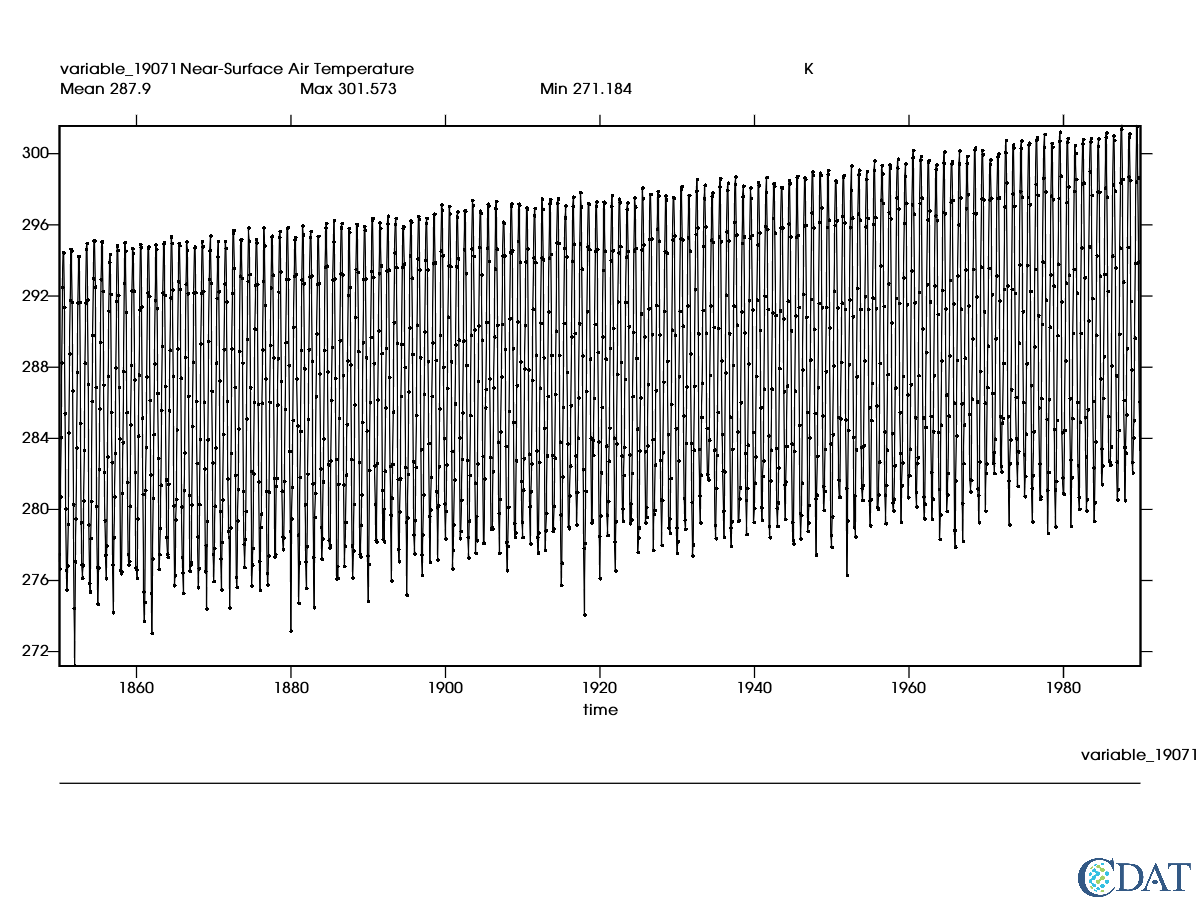

In [24]:
x = vcs.init(bg=True, geometry=(1200,900))
line = vcs.create1d()
line.markersize = .5
x.plot(datamskd_ts, line)

Next we'll remove the annual cycle using the `ANNUALCYCLE.departures` method as we did in executing Option 1 above. Again, the method calculates an average temperature value for each month of the year and determines the departure of the temperature at each time value from the average monthly temperature, effectively removing the annual cycle from the data.

In [25]:
datamskd_ts_departures = cdutil.times.ANNUALCYCLE.departures(datamskd_ts)
datamskd_ts_departures.shape

(1680,)

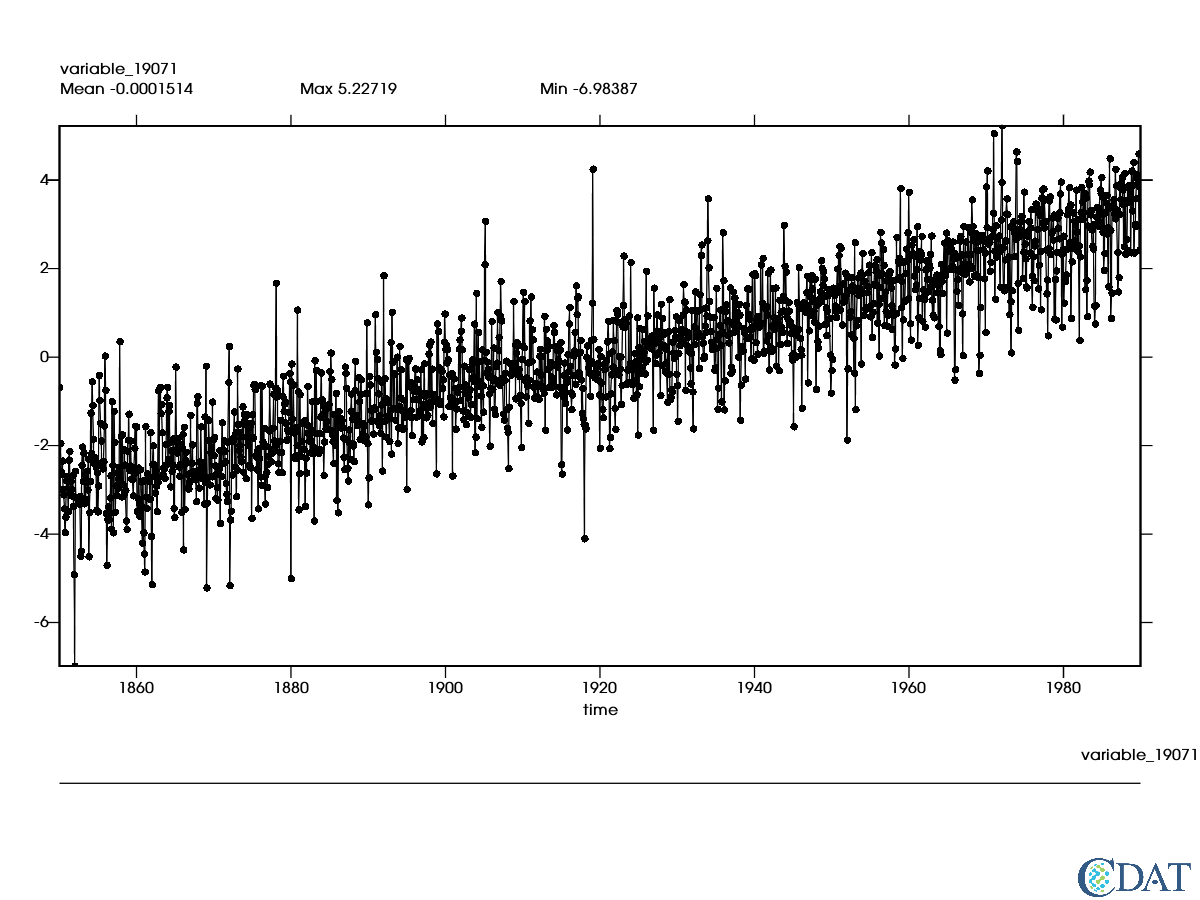

In [26]:
x.clear()
x.plot(datamskd_ts_departures)

It is difficult to discern a difference between the time series produced by the two different procedures, so let's plot their difference: `datamskd_departures_ts_corrected` (remove annual cycle at each grid cell, then spatially average to create a single time series) minus `datamskd_ts_departures` (spatially average to create a single time series, then remove annual cycle). This is the difference between processing Option 1 and Option 2.

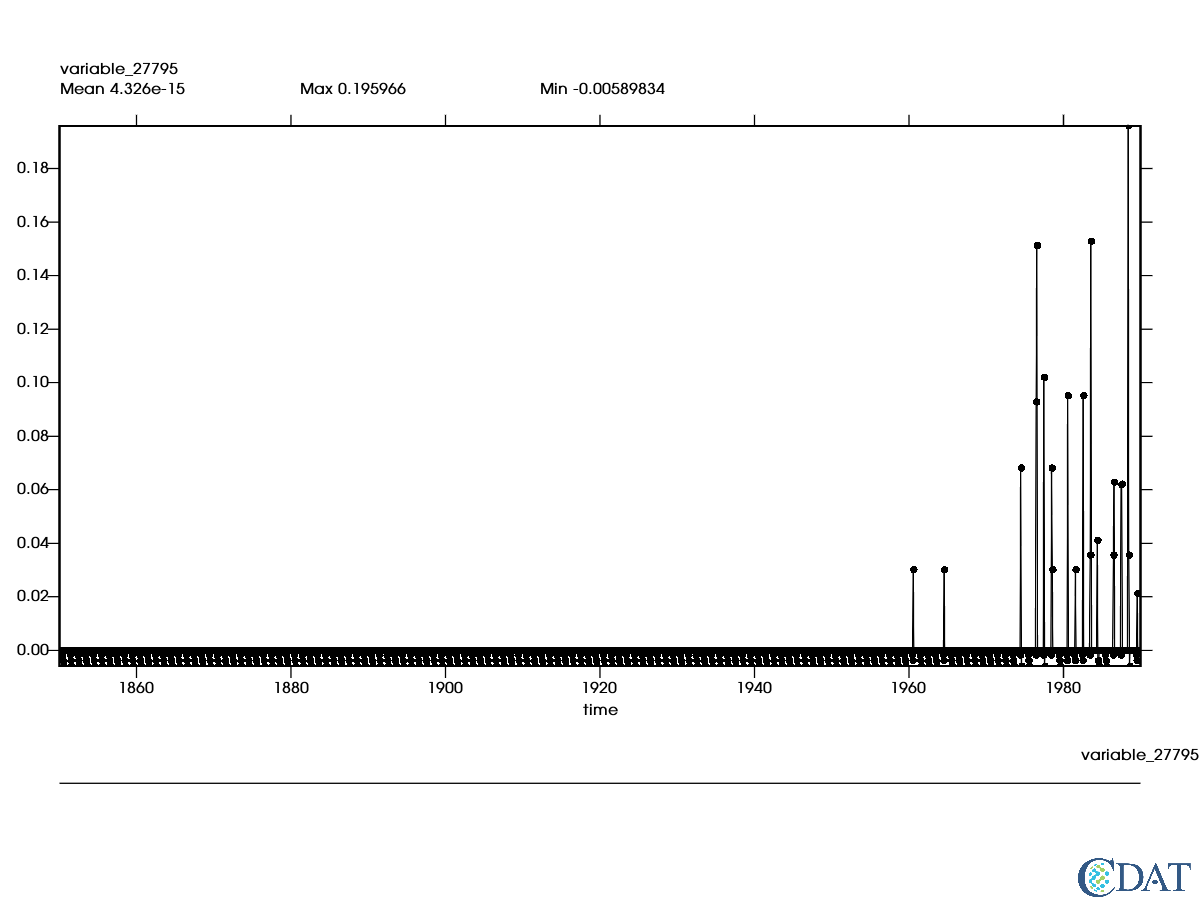

In [27]:
x.clear()
x.plot(datamskd_departures_ts_corrected - datamskd_ts_departures)

Note that the order of operations matters because there are missing data. The two time series are slightly different in some of the warmer (i.e., later) years, where data values may be "missing" because they exceed the temperature threshold (2 degrees cooler than the maximum temperature). If the order of operations did not matter (as in datasets without missing data), the two time series would be identical.

For the case considered above, computing the area mean time-series before removing the climatological annual cycle ("Processing Option 2") can be misleading. Recall that the missing data occur in the warmest part of the domain during the warmest part of the year. When these values are "missing", we reduce the regional mean (for months with missing data), leading to an artificially cool month for that time of year (i.e., the regional-mean anomaly can become negative solely because the warm temperatures are missing over some of the region during that month). Note that if the values were "missing" for a given grid cell every year at the same time of year, then they would not affect the regional mean and would not lead to unrealistic anomalies, but the values are only missing in the later part of the period considered.

In contrast, "Processing Option 1" first removes the climatological annual cycle at each grid cell. Now the departures reflect true anomalies from the normal monthly temperature everywhere, and when they are spatially averaged, the result usually better represents the true regional mean anomalies.

# Detrend Data
[Back to Top](#top)

## Consider Two Options

We apply standard linear regression formulas to compute the slope (a) and intercept (b) of the trend line: T = a\*t + b where T = temperature departures (from the climatological annual cycle), and t = time.  

Starting with the modified temperature dataset that includes "missing" values, we shall again consider how the order of operations affects the result of removing the trend.  **Under both options below, the first step is to remove the climatological mean annual cycle from the time series of each grid cell (as described above, `datamskd_departures`).**  Then we must decide which of the following processing procedures is most appropriate for a particular application: 

- Processing Option A: Spatially average the fields over the domain and remove the trend from the resulting time-series.
- Processing Option B: Remove the trend at each grid cell and then spatially average the results.

Under Option B, the resulting time-series may include a residual trend (and a residual non-zero mean), so an additional step can be applied, as discussed below, to obtain a true anomaly field that has been fully detrended.

----
First we will compute the trend over time. To do this we determine the slope (or coefficient) and intercept of the trend line where y = a*x + b and y = temperature; a = coefficent; x = time; and b = the intercept.

To remind ourselves of the dimensions of the ```datamskd_departures``` variable before we calculate the coefficient and intercept, let's look at the shape of the ```datamskd_departures``` variable which is the masked temperature data across the US with the annual cycle removed.

In [28]:
datamskd_departures.shape

(1680, 13, 16)

Now let's calculate the coefficient and the intercept of the trend as a function of latitude and longitude, which gives a single trend line over time for each grid cell. 

The index of time ```t``` can be expressed in any units (days, months, years, etc.) and `genutil` will determine its index.
**QUESTION FOR CHARLES: WHAT IS MEANT BY INDEX? IS IT THE LOCATION OF THE DIMENSION AS IN "TIME IS DIMENSION 0"?**

After computation we lose the time axis. 

The units for the coefficent are `K/day` since the time axis units are in `days since XXX`. **ASK KARL - DATA IS MONTHLY DATA, NOT DAILY SO SHOULDN'T THE UNITS BE K/MONTH?**

The units for the intercept are `K` since y is temperature. 

In [29]:
coeff, intercept = genutil.statistics.linearregression(datamskd_departures, axis="t")
print("Shapes: coeff {}, intercept {}".format(coeff.shape, intercept.shape))

Shapes: coeff (13, 16), intercept (13, 16)


Let's perform the same coefficient and intercept calculation for the time series (after we've removed the annual cycle). Again we'll remind ourselves of the dimensions of the data in the ```datamskd_departures_ts``` variable which represents a single temperature value for each time value in the dataset (after the annual cycle has been removed).

In [30]:
datamskd_departures_ts.shape

(1680,)

Calculating the coefficent and intercept:

In [31]:
coeff_ts, intercept_ts = genutil.statistics.linearregression(datamskd_departures_ts, axis="t")

For this time series, since it has no latitude or longitude dimensions (each temperature value represents the whole area of the dataset, namely the US), the coefficent and intercept are for a trend line and there is no latitude or longitude dimension to the resulting coefficient and intercept. The fact that no value is displayed within the ( ) means there is no dimensional information for that value and it is a scalar (i.e. just a number).

In [32]:
print("Shapes: coeff_ts {}, intercept_ts {}".format(coeff_ts.shape, intercept_ts.shape))

Shapes: coeff_ts (), intercept_ts ()


## Removing the Trend
[Back to Top](#top)

Before we can remove the warming trend in the data, we need to standardize the time axis. We use the ```.getTime``` and ```.setAxis``` methods on the masked data (```datamskd```) and store the result in the variable `times`.

**QUESTION FOR CHARLES: IS STANDARDIZING THE TIME AXIS A TRUE STATEMENT OF WHY WE NEED TO USE .getTime AND .setAxis? OR DO WE RUN THE NEXT TWO LINES OF CODE TO GIVE US A TIME AXIS WE CAN USE FOR GROWING THE COEFFICIENT AND INTERCEPT OF ```datamskd_departures``` (THE MASKED DATA WHERE THE ANNUAL CYCLE HAS BEEN REMOVED BUT THE TIME SERIES HAS NOT YET BEEN CREATED)? OR ARE BOTH REASONS VALID?**

In [33]:
times = MV2.array(datamskd.getTime()[:])
times.setAxis(0, datamskd.getTime())
times.shape

(1680,)

In [34]:
times.info

<bound method AbstractVariable.info of variable_28016
masked_array(data=[1.55000e+01, 4.50000e+01, 7.45000e+01, ...,
                   5.10235e+04, 5.10540e+04, 5.10845e+04],
             mask=False,
       fill_value=1e+20)
>

**QUESTION FOR CHARLES: IS ```.info``` THE BEST WAY TO SEE WHAT THE FIRST FEW VALUES OF A VARIBLE ARE OR IS THERE A BETTER WAY?**

Since time is not necessarily ***on index 0***, we need to use the grower function to expand the ```times``` variable to cover the entire area of the dataset which will add the latitude and longitude dimensions back in. The ```.grower``` method takes the values in the second argument (the 1-dimensional `times` variable here) and copies (or grows) the values to match the dimensions of the first argument (the 3-dimensional ```datamskd_departures``` variable here) to yield variables (```tmp``` and ```full_times```) with the same dimensions as the first argument).

We use data as the first argument to ensure the same order.

**QUESTIONS FOR CHARLES:**
1. WHAT DOES "on index 0" mean? IS IT "Since time is not necessarily the 0th dimension"? AND IF SO, HOW IS THAT POSSIBLE? OR DO YOU MEAN "Since `times` is not a 3-dimensional variable, but it needs to be for future calculations, we need to use the grower function..."?

2. WHEN YOU SAY "We use data as the first argument to ensure the same order." DO YOU MEAN THE SAME ORDER OF THE DIMENSIONS (13, 16) (BUT HOW COULD THE DIMENSIONS BE IN A DIFFERENT ORDER LIKE (16, 13)? OR DO YOU MEAN SOMETHING LIKE "We use ```datamskd_departures``` as the first argument to ensure the resulting data variable has the same dimensions as ```datamskd_departures```."

3. WHY ARE YOU USING ```datamskd_departures``` TO CREATE full_times, BUT ```datamskd``` TO GROW ```coeff``` AND ```intercept```? COULD WE USE ```datamskd_departures``` FOR ALL THREE GROWER COMMANDS - THAT 1ST ARGUMENT IS JUST TO SUPPLY THE DIMENSIONS, CORRECT? NO ACTUAL VALUES FROM THE 1ST ARGUMENT ARE USED IN THE .grower METHOD, ARE THEY?

4. WHAT IS THE ```tmp``` VARIABLE USED FOR? IT DOESN'T SEEM TO BE USED ANYWHERE AFTER IT IS CREATED.

In [35]:
tmp, full_times = genutil.grower(datamskd_departures, times)
print("Shapes: tmp {}, full_times {}".format(tmp.shape, full_times.shape))

Shapes: tmp (1680, 13, 16), full_times (1680, 13, 16)


In [36]:
full_times.info

<bound method AbstractVariable.info of variable_28029
masked_array(
  data=[[[1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01],
         [1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01],
         [1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01],
         ...,
         [1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01],
         [1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01],
         [1.55000e+01, 1.55000e+01, 1.55000e+01, ..., 1.55000e+01,
          1.55000e+01, 1.55000e+01]],

        [[4.50000e+01, 4.50000e+01, 4.50000e+01, ..., 4.50000e+01,
          4.50000e+01, 4.50000e+01],
         [4.50000e+01, 4.50000e+01, 4.50000e+01, ..., 4.50000e+01,
          4.50000e+01, 4.50000e+01],
         [4.50000e+01, 4.50000e+01, 4.50000e+01, ..., 4.50000e+01,
          4.50000

Now apply the same "grower" function to the coefficient.
As a reminder, we'll view the shape of ```coeff``` first.

In [37]:
coeff.shape

(13, 16)

In [38]:
tmp, coeff_full = genutil.grower(datamskd, coeff)
print("Shapes: tmp {}, coeff_full {}".format(tmp.shape, coeff_full.shape))

Shapes: tmp (1680, 13, 16), coeff_full (1680, 13, 16)


Now grow the intercept.
Again, as a reminder, we'll view the shape of ```intercept``` first.

In [39]:
intercept.shape

(13, 16)

In [40]:
tmp, intercept_full = genutil.grower(datamskd, intercept)
print("Shapes: tmp {}, intercept_full {}".format(tmp.shape, intercept_full.shape))

Shapes: tmp (1680, 13, 16), intercept_full (1680, 13, 16)


To remove the trend from the spatially distributed data, we take the ```datamskd_departures``` (the masked data with the annual cycle removed) and subtract the trend plane which is represented by the right-hand side of the equation y = a*x + b which is ```full_times * coeff_full + intercept_full```.   (The right side of the equation becomes ```- full_times * coeff_full - intercept_full``` when you subtract it from ```datamskd_departures```.)

**QUESTION FOR KARL: IS THE TREND A "PLANE" OR IS IT "A SINGLE TREND LINE FOR EACH GRID CELL" AS MENTIONED ABOVE?**

**QUESTION FOR CHARLES AND/OR KARL: WHY DO THE ```coeff_full``` AND ```intercept_full``` HAVE A TIME DIMENSION? ABOVE ```coeff``` AND ```intercept``` HAD ONLY LAT AND LONG DIMENSIONS.**

In [41]:
datamskd_departures_detrend = datamskd_departures - full_times * coeff_full - intercept_full
datamskd_departures_detrend.shape

(1680, 13, 16)

To remove the trend from the masked data that has had the annual cycle removed and has been converted to a time series (```datamskd_departures_ts```), we subtract the corresponding values for "a" (```times```), the coefficient (```coeff_ts```) and the intercept (```intercept_ts```). 

To remind us of the dimensions of these values, we'll take a quick look at the shapes of the values before removing the trend. As mentioned above, if no value is displayed within the ( ), that means there is no dimensional information for that value and it is a scalar (i.e. just a number).

In [42]:
datamskd_departures_ts.shape

(1680,)

In [43]:
times.shape

(1680,)

In [44]:
coeff_ts.shape

()

In [45]:
intercept_ts.shape

()

In [46]:
datamskd_departures_ts_detrend = datamskd_departures_ts - times * coeff_ts - intercept_ts
datamskd_departures_ts_detrend.shape

(1680,)

Now we'll plot the time series with the trend removed.

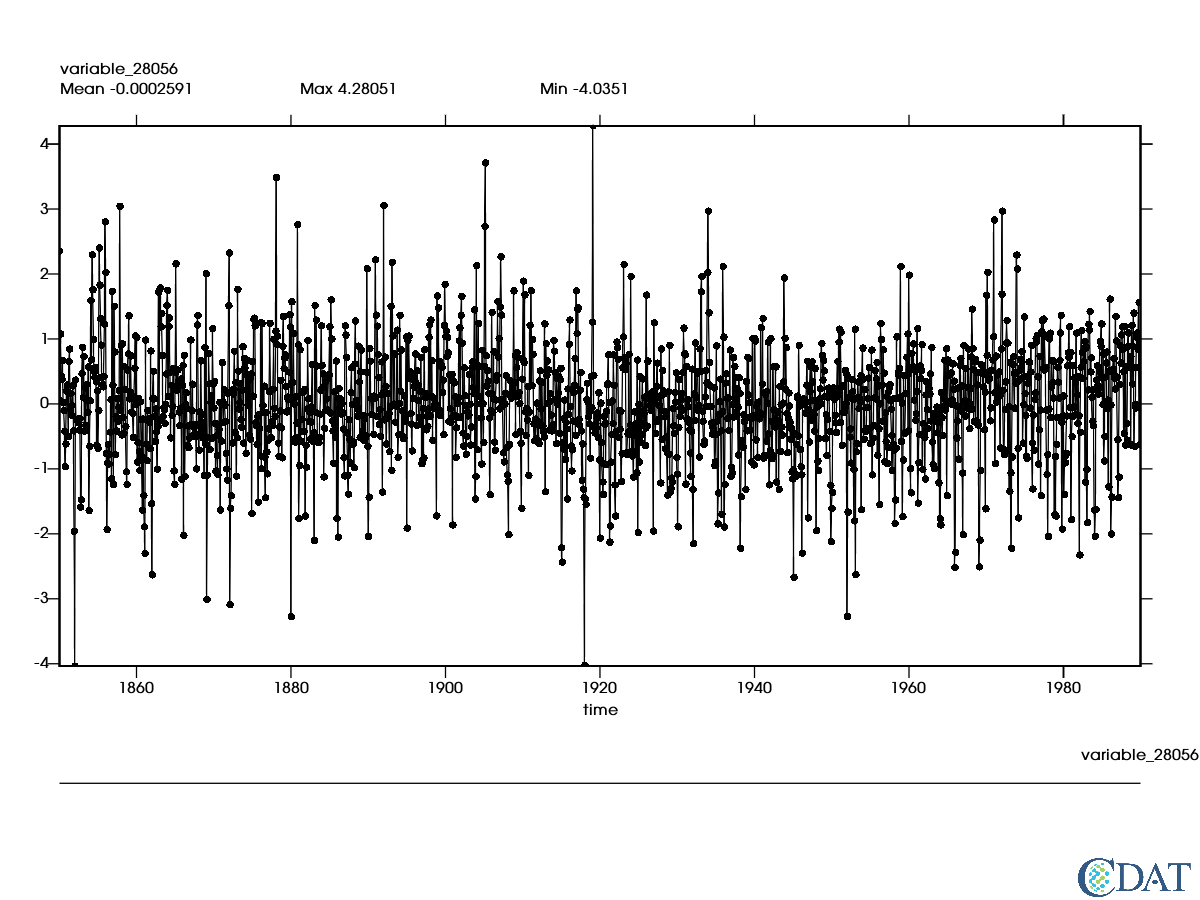

In [47]:
x.clear()
x.plot(datamskd_departures_ts_detrend)

Here, again, the order matters.

For comparison, we'll create a time series from the masked data with both the annual cycle and the warming trend removed and call it ```datamskd_departures_detrend_ts```.

In [48]:
datamskd_departures_detrend_ts = genutil.averager(datamskd_departures_detrend, axis='xy')
datamskd_departures_detrend_ts.shape

(1680,)

Now that we have two different ways we've gotten to the end result, we'll subtract one from the other and plot the difference. 

(To recap: ```datamskd_departures_detrend_ts``` was created by removing the annual cycle from the masked data, then removing the trend, then creating a time series by averaging over the whole spatial area of the dataset, and ```datamskd_departures_ts_detrend``` was created by removing the annual cycle from the masked data, then creating a spatially averaged time series, then removing the warming trend.)

The correct way to perform these steps is to remove the annual cycle from the masked data, then create a spatially averaged time series, then remove the warming trend (```datamskd_departures_ts_detrend```).

**QUESTION: DID I ACCURATELY REPRESENT THE CORRECT WAY TO DO THINGS?**

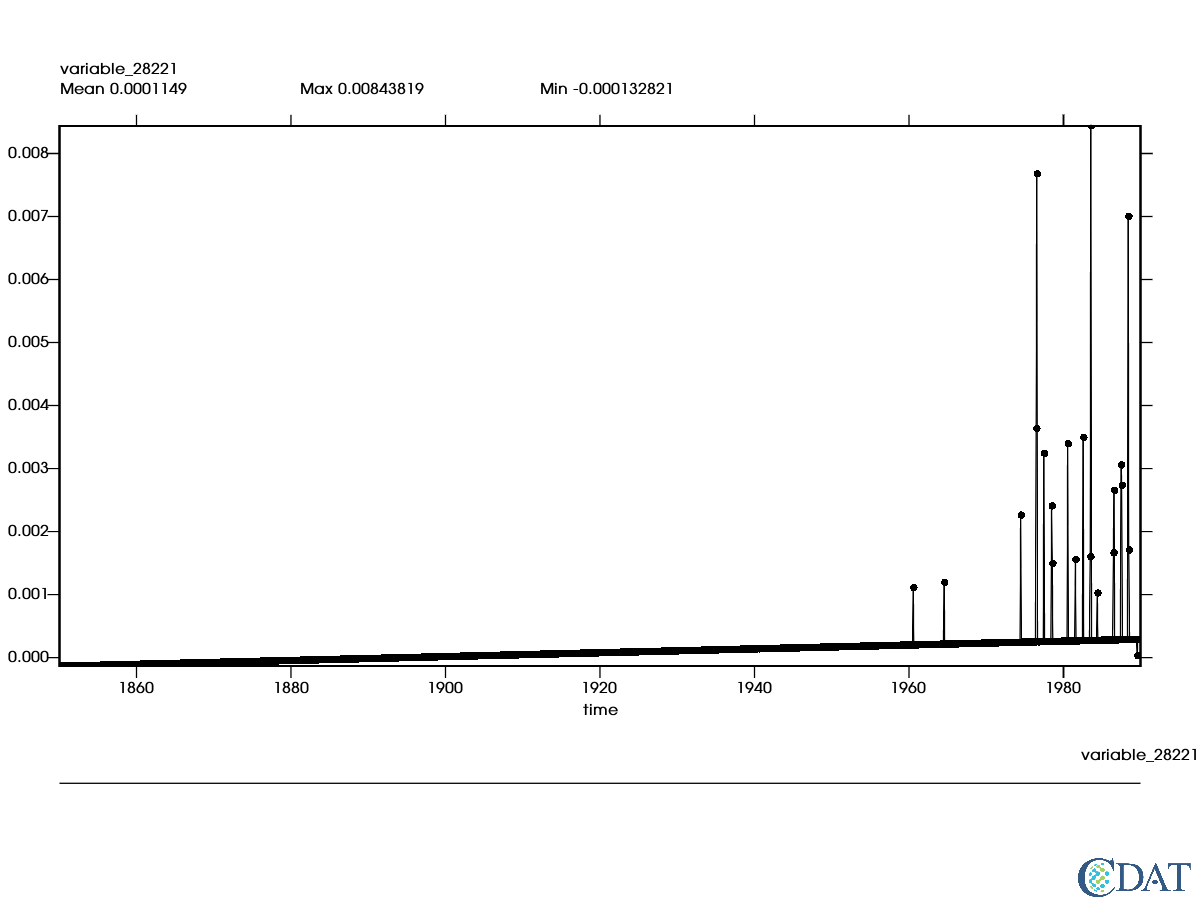

In [49]:
x.clear()
x.plot(datamskd_departures_detrend_ts - datamskd_departures_ts_detrend)

**QUESTION TO RESOLVE: WHY IS THERE A TREND TO THIS DATA? THE PREVIOUS "SUBTRACTIVE" PLOT HAD 0 VALUES WHERE THERE WAS NO DIFFERENCE BETWEEN THE TWO METHODS OR TEST CASES.**

[Back to Top](#top)

The CDAT software was developed by LLNL. This tutorial was written by Charles Doutriaux, Holly Davis, and Karl Taylor. This work was performed under the auspices of the U.S. Department of Energy by Lawrence Livermore National Laboratory under Contract DE-AC52-07NA27344.

If you have questions about this notebook, please email our [CDAT Support](cdat-support@llnl.gov) address, cdat-support@llnl.gov.